In [1]:
from cohirf.experiment.hpo_gaussian_clustering_experiment import HPOGaussianClusteringExperiment
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
import optuna
from cohirf.models.cohirf import CoHiRF, BaseCoHiRF

In [2]:
def plot_results(results, time="hpo_time", log_time=False):
    results = results.copy()
    x_axis_label = "Standard Deviation"
    y_axis_label_metric = "Adjusted Rand Index (ARI)"
    y_axis_label_time = "Time (s)"
    results.rename(
        columns={"std": x_axis_label, "ari": y_axis_label_metric, time: y_axis_label_time, "model": "Model"},
        inplace=True,
    )
    plt.style.use("seaborn-v0_8-whitegrid")
    with mpl.rc_context(
        rc={
            "figure.constrained_layout.use": True,
            "savefig.bbox": "tight",
            "figure.figsize": (12, 7),
            "legend.loc": "upper left",
            "legend.frameon": True,
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 15,
            "xtick.labelsize": 13,
            "ytick.labelsize": 13,
            "axes.grid": True,
            "grid.color": "grey",
            "grid.alpha": 0.3,
        }
    ):
        fig, axs = plt.subplots(2, 1, sharex=True)
        axs = axs.flatten()
        palette = sns.color_palette("tab10", n_colors=len(results["Model"].unique()))
        # Time plot
        ax = sns.lineplot(
            data=results,
            x=x_axis_label,
            y=y_axis_label_time,
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[0],
            palette=palette,
        )
        if log_time:
            ax.set_yscale("log")
        ax.set_ylabel(y_axis_label_time)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        # ARI plot
        ax2 = sns.lineplot(
            data=results,
            x=x_axis_label,
            y=y_axis_label_metric,
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[1],
            palette=palette,
        )
        ax2.set_ylabel(y_axis_label_metric)
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
        # Remove duplicate legends
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
        ax.get_legend().remove()
        ax2.get_legend().remove()
        plt.xlabel(x_axis_label)
        plt.tight_layout()
        plt.show()
        return fig, axs

In [3]:
results_dir = Path("/home/belucci/code/cohirf/results") / "gaussian_noise_intra"
results_dir.mkdir(parents=True, exist_ok=True)
mlflow_tracking_uri = f"sqlite:///{results_dir}/mlflow.db"
experiment_params = dict(
    mlflow_tracking_uri=mlflow_tracking_uri,
    check_if_exists=False,
    verbose=1,
)

In [4]:
dataset_params = dict(
    n_features_dataset=None,
    n_centers=5,
    n_random_features=0,
    pct_random_features=None,
)

In [5]:
all_results = (
    pd.read_csv(results_dir / "gaussian_noise_intra_results.csv")
    if (results_dir / "gaussian_noise_intra_results.csv").exists()
    else pd.DataFrame()
)

In [5]:
all_results = pd.DataFrame()

# KMeans

In [6]:
seeds = [i for i in range(3)]
model = "KMeans"
standardize = False
results = []
n_samples = int(1e3)
n_informative_features = int(1e4)
distance = 2 * n_informative_features**0.5
stds = [10, 15, 20, 25, 30, 35, 40]
combinations = list(product(seeds, stds))
for seed, std in combinations:
    print(f"Running combination: seed={seed}, std={std}")
    experiment = HPOGaussianClusteringExperiment(
        # hpo
        n_trials=30,
        hpo_seed=seed,
        hpo_metric="adjusted_rand",
        direction="maximize",
        # model
        experiment_name=model,
        model=model,
        seed_model=seed,
        # dataset
        seed_dataset=seed,
        std=std,
        standardize=standardize,
        n_samples=n_samples,
        n_informative_features=n_informative_features,
        distance=distance,
        **dataset_params,
        **experiment_params,
    )
    result = experiment.run(return_results=True)[0]
    ari = result["evaluate_model_return"]["best/adjusted_rand"]
    hpo_time = result["fit_model_return"]["elapsed_time"]
    best_time = result["evaluate_model_return"]["best/elapsed_time"]
    results.append(
        dict(
            ari=ari,
            hpo_time=hpo_time,
            best_time=best_time,
            seed=seed,
            std=std,
            model=model,
            standardize=standardize,
            n_samples=n_samples,
            n_informative_features=n_informative_features,
            distance=distance,
        )
    )
    clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running combination: seed=0, std=10


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

2025/10/23 14:13:24 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/23 14:13:24 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Trials:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
all_results = pd.concat([all_results, results], ignore_index=True)

/tmp/ipykernel_1972366/2624980314.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


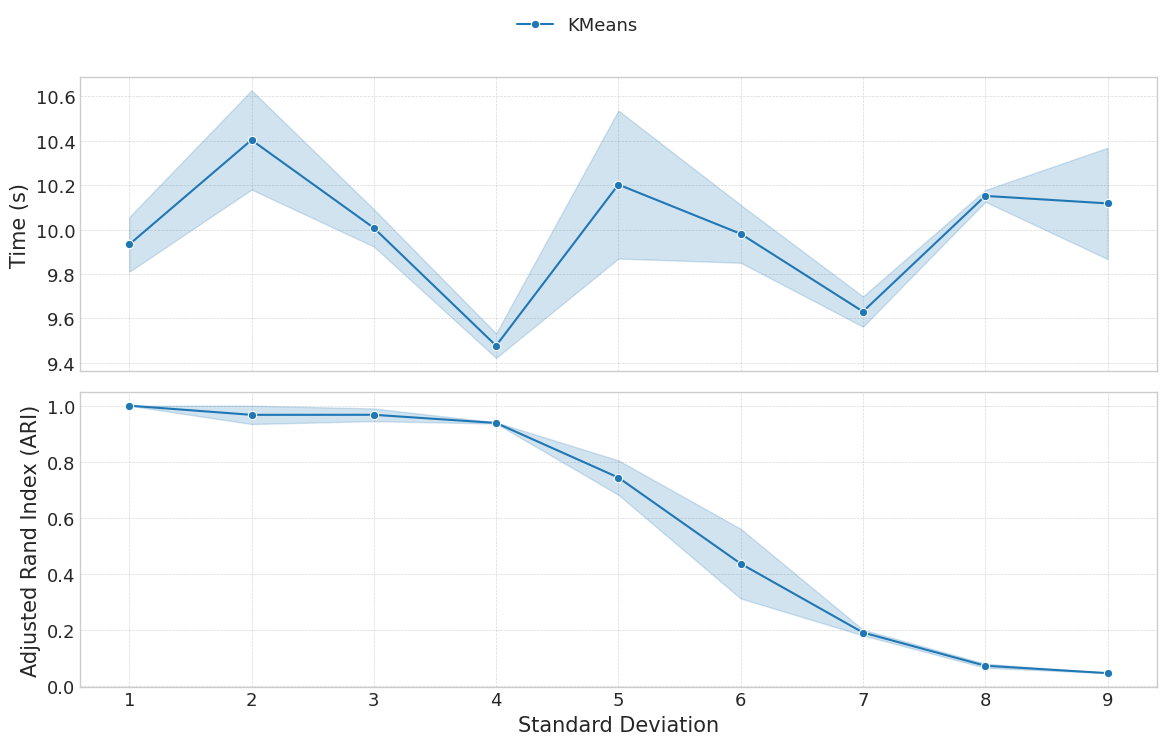

(<Figure size 1200x700 with 2 Axes>,
 array([<Axes: xlabel='Standard Deviation', ylabel='Time (s)'>,
        <Axes: xlabel='Standard Deviation', ylabel='Adjusted Rand Index (ARI)'>],
       dtype=object))

In [16]:
plot_results(
    all_results.loc[
        (all_results["model"].isin(["KMeans", "CoHiRF"]))
        & (all_results["n_samples"] == n_samples)
        & (all_results["n_informative_features"] == n_informative_features)
        & (all_results["distance"] == distance)
        & (all_results["std"] <= 10)
    ],
    time="hpo_time",
    log_time=False,
)

# CoHiRF

In [6]:
model = CoHiRF
model_params = dict(consensus_strategy="top-down-inv")
search_space = dict(
    n_features=optuna.distributions.FloatDistribution(0.1, 1.0),
    repetitions=optuna.distributions.IntDistribution(2, 10),
    kmeans_n_clusters=optuna.distributions.IntDistribution(2, 5),
)
default_values = [
    dict(
        n_features=0.3,
		repetitions=3,
        kmeans_n_clusters=3,
    )
]
model_name = "CoHiRF-top-down-inv"

In [7]:
seeds = [0, 1]
standardize = True
results = []
n_samples = int(1e2)
n_informative_features = int(1e2)
distance = 2 * n_informative_features**0.5
stds = [1, 2, 3, 4, 5, 6, 7, 8, 9]
combinations = list(product(seeds, stds))
for seed, std in combinations:
    print(f"Running combination: seed={seed}, std={std}")
    experiment = HPOGaussianClusteringExperiment(
        # hpo
        n_trials=30,
        hpo_seed=seed,
        hpo_metric="adjusted_rand",
        direction="maximize",
        # model
        experiment_name=model_name,
        model=model,
        model_params=model_params,
        search_space=search_space,
        default_values=default_values,
        seed_model=seed,
        n_jobs=10,
        # dataset
        seed_dataset=seed,
        std=std,
        standardize=standardize,
        n_samples=n_samples,
        n_informative_features=n_informative_features,
        distance=distance,
        **dataset_params,
        **experiment_params,
    )
    result = experiment.run(return_results=True)[0]
    ari = result["evaluate_model_return"]["best/adjusted_rand"]
    hpo_time = result["fit_model_return"]["elapsed_time"]
    best_time = result["evaluate_model_return"]["best/elapsed_time"]
    results.append(
        dict(
            ari=ari,
            hpo_time=hpo_time,
            best_time=best_time,
            seed=seed,
            std=std,
            model=model_name,
            standardize=standardize,
            n_samples=n_samples,
            n_informative_features=n_informative_features,
            distance=distance,
        )
    )
    clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running combination: seed=1, std=9


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-package

In [8]:
all_results = pd.concat([all_results, results], ignore_index=True)

/tmp/ipykernel_2434384/2624980314.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


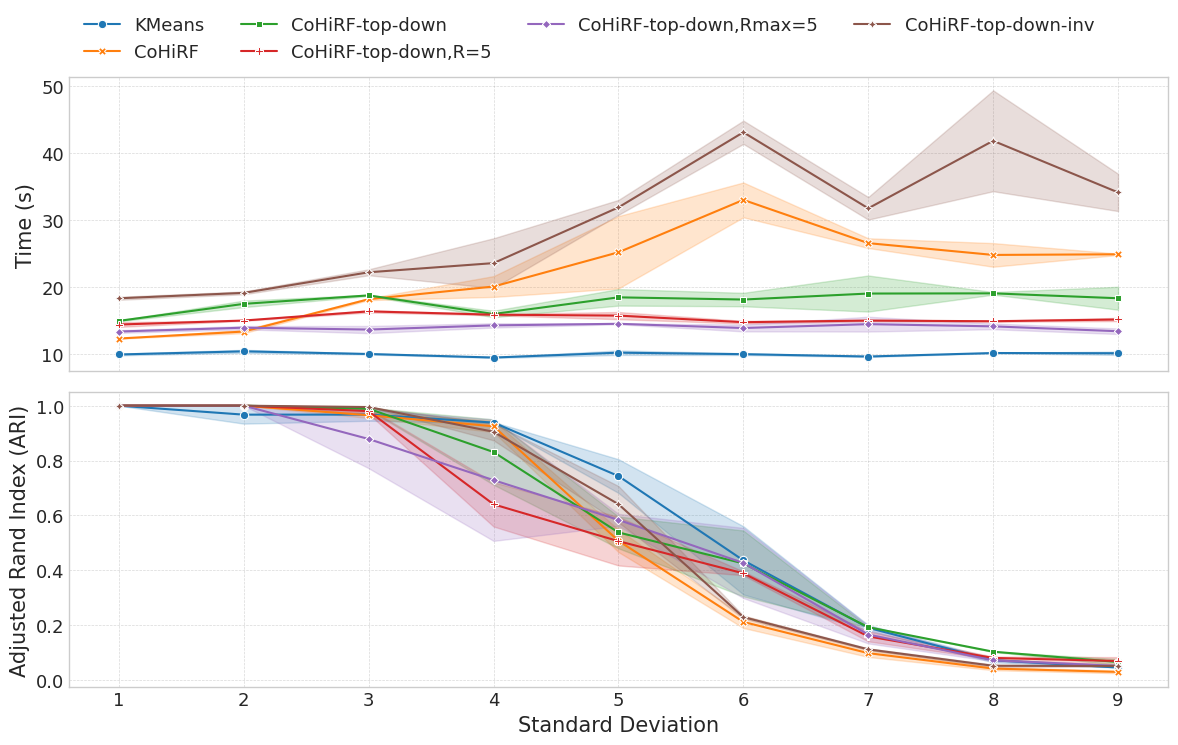

(<Figure size 1200x700 with 2 Axes>,
 array([<Axes: xlabel='Standard Deviation', ylabel='Time (s)'>,
        <Axes: xlabel='Standard Deviation', ylabel='Adjusted Rand Index (ARI)'>],
       dtype=object))

In [9]:
plot_results(
    all_results.loc[
        (all_results["n_samples"] == n_samples)
        & (all_results["n_informative_features"] == n_informative_features)
        & (all_results["distance"] == distance)
		& (all_results["std"] <= 10)
		# & (all_results["model"].isin(["KMeans", "CoHiRF-R=2,top-down", "CoHiRF-R=2"]))
    ],
    time="hpo_time",
    log_time=False,
)

In [34]:
all_results.to_csv(results_dir / "gaussian_noise_intra_results.csv", index=False)

In [43]:
seed = 0
seeds = [1]
model = "CoHiRF"
standardize = True
results = []
n_samples = int(1e2)
n_informative_features = int(1e2)
distance = 2 * n_informative_features**0.5
stds = [1, 2, 3, 4, 5, 6, 7, 8, 9]
combinations = list(product(seeds, stds))
for seed, std in combinations:
    print(f"Running combination: seed={seed}, std={std}")
    experiment = HPOGaussianClusteringExperiment(
        # hpo
        n_trials=30,
        hpo_seed=seed,
        hpo_metric="adjusted_rand",
        direction="maximize",
        # model
        experiment_name=model,
        model=model,
        seed_model=seed,
        model_params=dict(consensus_strategy="top-down"),
        # dataset
        seed_dataset=seed,
        std=std,
        standardize=standardize,
        n_samples=n_samples,
        n_informative_features=n_informative_features,
        distance=distance,
        **dataset_params,
        **experiment_params,
    )
    result = experiment.run(return_results=True)[0]
    ari = result["evaluate_model_return"]["best/adjusted_rand"]
    hpo_time = result["fit_model_return"]["elapsed_time"]
    best_time = result["evaluate_model_return"]["best/elapsed_time"]
    results.append(
        dict(
            ari=ari,
            hpo_time=hpo_time,
            best_time=best_time,
            seed=seed,
            std=std,
            model=model+" (top-down)",
            standardize=standardize,
            n_samples=n_samples,
            n_informative_features=n_informative_features,
            distance=distance,
        )
    )
    clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running combination: seed=1, std=9


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-package

In [44]:
results

,ari,hpo_time,best_time,seed,std,model,standardize,n_samples,n_informative_features,distance
0,1.000000,14.688213,0.047785,1,1,CoHiRF (top-down),True,100,100,20.0
1,0.997501,15.558273,0.311222,1,2,CoHiRF (top-down),True,100,100,20.0
2,0.813347,26.025696,0.073498,1,3,CoHiRF (top-down),True,100,100,20.0
3,0.721500,26.260668,0.034650,1,4,CoHiRF (top-down),True,100,100,20.0
4,0.335565,21.643685,0.025047,1,5,CoHiRF (top-down),True,100,100,20.0
5,0.103927,17.479342,0.031498,1,6,CoHiRF (top-down),True,100,100,20.0
6,0.067262,20.871214,0.059193,1,7,CoHiRF (top-down),True,100,100,20.0
7,0.021268,25.714742,0.200551,1,8,CoHiRF (top-down),True,100,100,20.0
8,0.035512,18.919414,0.120651,1,9,CoHiRF (top-down),True,100,100,20.0


In [45]:
all_results = pd.concat([all_results, results], ignore_index=True)

/tmp/ipykernel_36068/2624980314.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


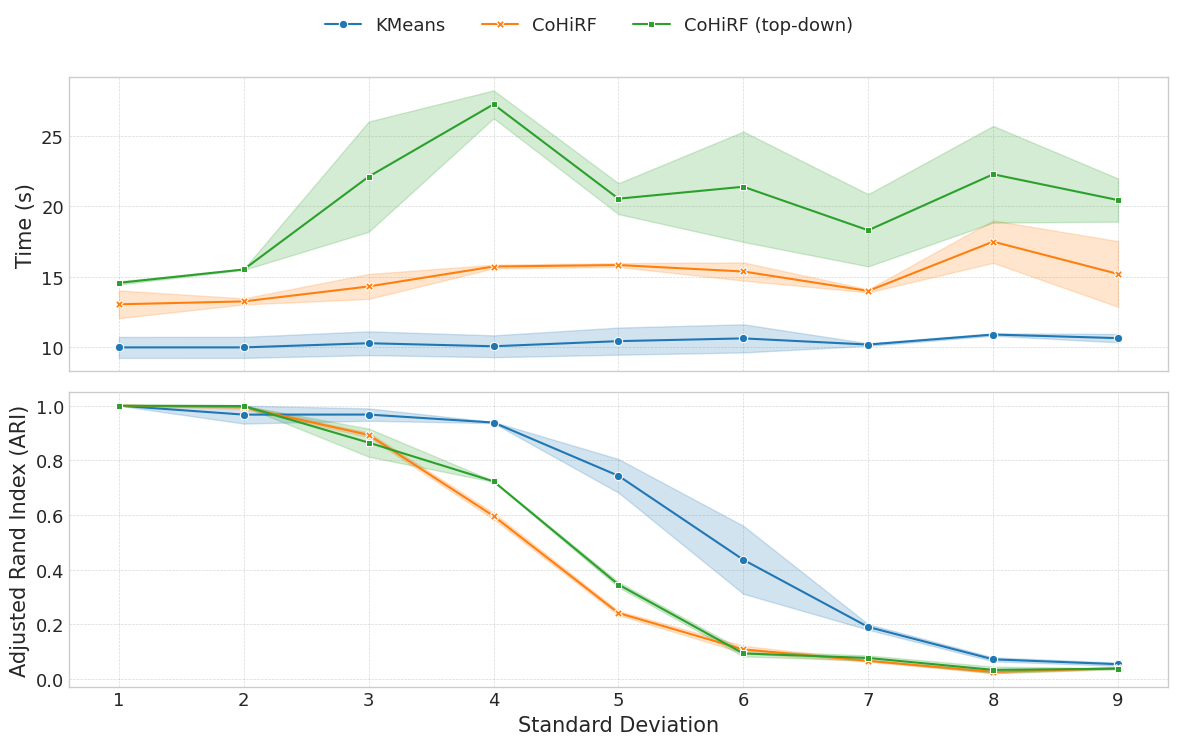

(<Figure size 1200x700 with 2 Axes>,
 array([<Axes: xlabel='Standard Deviation', ylabel='Time (s)'>,
        <Axes: xlabel='Standard Deviation', ylabel='Adjusted Rand Index (ARI)'>],
       dtype=object))

In [46]:
plot_results(
    all_results.loc[
        # (all_results["model"].isin(["KMeans", "CoHiRF"]))
        (all_results["n_samples"] == n_samples)
        & (all_results["n_informative_features"] == n_informative_features)
        & (all_results["distance"] == distance)
        & (all_results["std"] <= 10)
    ],
    time="hpo_time",
    log_time=False,
)

In [5]:
from cohirf.experiment.gaussian_clustering_experiment import GaussianClusteringExperiment

In [9]:
model = CoHiRF
model_params = dict(repetitions=2, consensus_strategy="factorize", consensus_threshold=0.8, n_features=0.8149061608620514, kmeans_n_clusters=2, verbose=1)
model_name = "CoHiRF-R=2"
standardize = True
results = []
n_samples = int(1e2)
n_informative_features = int(1e2)
distance = 2 * n_informative_features**0.5
std = 9
seed = 1
experiment = GaussianClusteringExperiment(
    # model
    experiment_name=model_name,
    model=model,
    model_params=model_params,
    n_jobs=1,
    seed_model=1180243456,
    # dataset
    seed_dataset=seed,
    std=std,
    standardize=standardize,
    n_samples=n_samples,
    n_informative_features=n_informative_features,
    distance=distance,
    verbose=1,
	raise_on_error=True,
    **dataset_params,
)
result = experiment.run(return_results=True)[0]
ari = result["evaluate_model_return"]["adjusted_rand"]

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Starting fit
Iteration 0
Starting consensus assignment
Starting repetition 0
Initialization complete
Iteration 0, inertia 73461.52205580988.
Iteration 1, inertia 40058.47403203894.
Iteration 2, inertia 39970.11165443775.
Iteration 3, inertia 39935.171544440665.
Iteration 4, inertia 39914.2225219532.
Iteration 5, inertia 39897.18588819921.
Iteration 6, inertia 39882.49366042262.
Iteration 7, inertia 39871.616292958104.
Iteration 8, inertia 39869.063470823996.
Iteration 9, inertia 39868.262712136144.
Converged at iteration 9: strict convergence.
Starting repetition 1
Initialization complete
Iteration 0, inertia 71636.1185441152.
Iteration 1, inertia 40071.76987162676.
Iteration 2, inertia 39986.83231208977.
Iteration 3, inertia 39947.04009379015.
Iteration 4, inertia 39926.466866763505.
Iteration 5, inertia 39913.48204045556.
Iteration 6, inertia 39905.430470801366.
Iteration 7, inertia 39903.873928934474.
Iteration 8, inertia 39902.29791669041.
Iteration 9, inertia 39900.68571294835.
It

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [8]:
ari

0.016491053336264265

In [10]:
ari

0.029461455065382027

In [7]:
y_pred1 = result["fit_model_return"]["y_pred"]

In [11]:
y_pred2 = result["fit_model_return"]["y_pred"]

In [12]:
y_pred1 == y_pred2

array([False,  True, False,  True, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False,  True, False, False, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True, False, False,
       False,  True, False, False, False, False,  True, False,  True,
        True, False, False, False,  True, False,  True, False,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True, False, False,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True, False,  True,  True,
       False,  True,